In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS
import clustering as clstr
import bout.assembly as bt
import bout.clustering as clstr
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline

from cli import get_file_paths

In [14]:
site_key = 'Carp'
freq_key = 'HF'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Carp Pond


In [15]:
location_df = pd.read_csv(f'../data/2022_detector_summaries/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022_kmeans.csv', index_col=0)

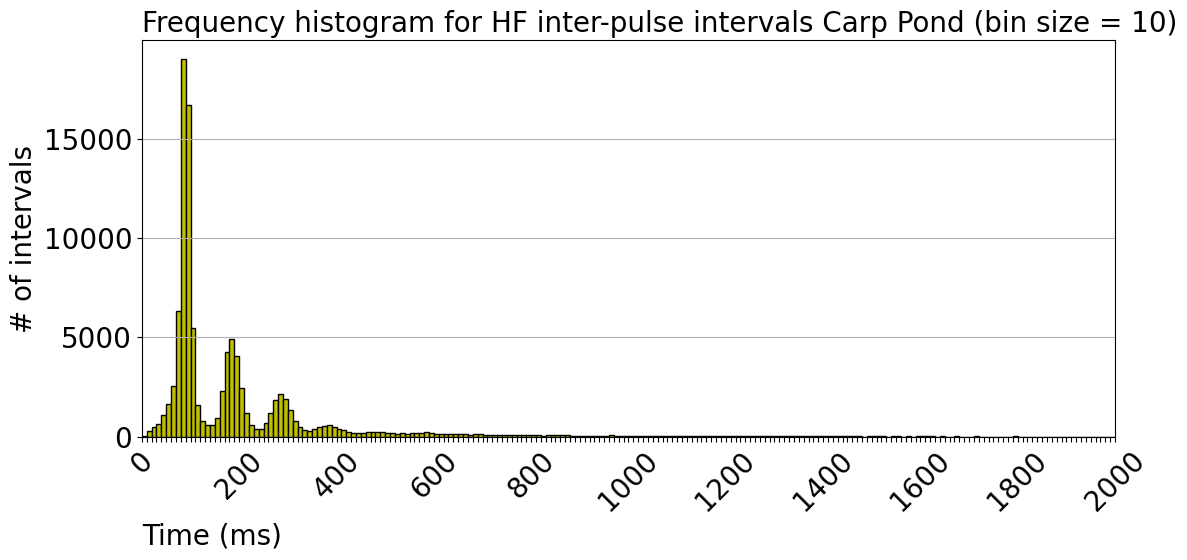

In [16]:
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df.copy(), fig_details)

In [17]:
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 1193583478 missassigned points
Slater method has 471497 missassigned points
Sibly method has 466382 missassigned points
Optim BCI has less misassignments than BCI? True
5115 more points assigned correctly


In [18]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.005333628542572338, intercept=11.681363618954414, rvalue=-0.9854630484172223, pvalue=1.219565079745454e-31, stderr=0.0001472372491115917, intercept_stderr=0.03421484482503524),
  'indices': range(0, 41),
  'lambda': 0.005333628542572338,
  'num_intervals_slater': 22188553.686419066},
 {'metrics': LinregressResult(slope=-3.1159576797701164e-07, intercept=5.918666840439488, rvalue=-0.9254751852343245, pvalue=0.0, stderr=1.0326223130834791e-10, intercept_stderr=0.0009148455577760446),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 3.1159576797701164e-07,
  'num_intervals_slater': 1193583477.8929164})

In [19]:
nlin_results

{'solution': array([2.19550599e+07, 5.39244753e-03, 1.19358349e+09, 3.11595769e-07]),
 'fast_num_intervals': 21955059.91009336,
 'fast_lambda': 0.005392447534118767,
 'slow_num_intervals': 1193583488.921459,
 'slow_lambda': 3.1159576930124437e-07,
 'bci': 1068.7945358832055}

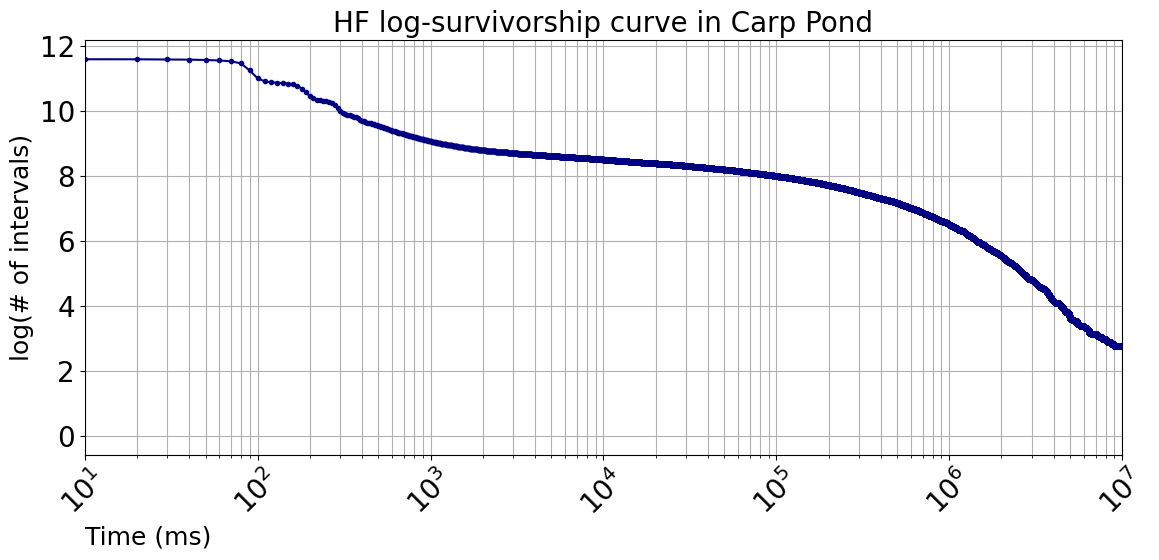

In [20]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

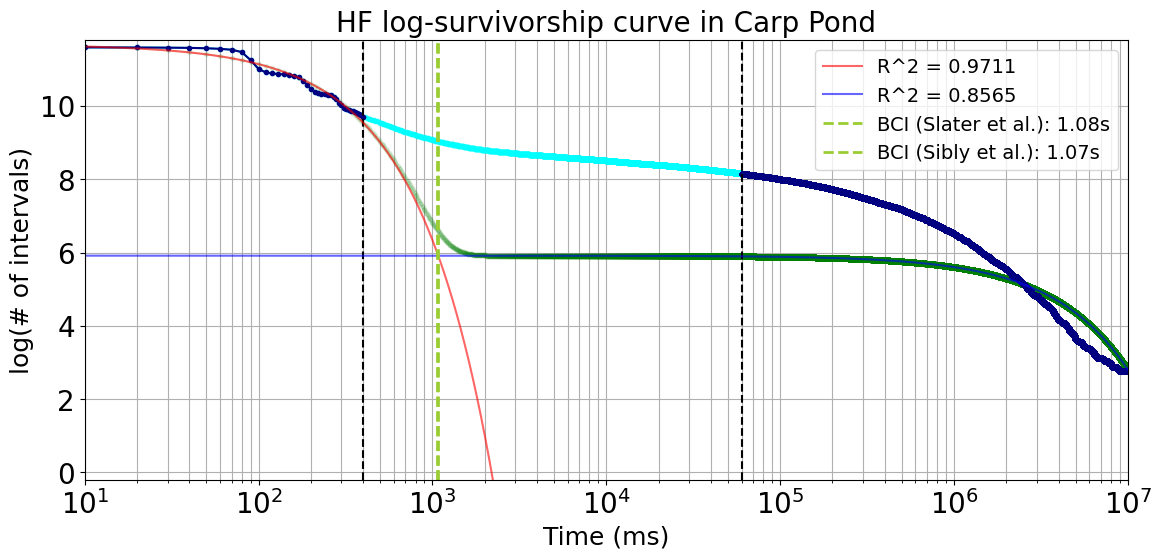

In [21]:
fig_details['time_end'] = 60000
fig_details['site_name'] = SITE_NAMES[site_key]
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1445640878 missassigned points
Slater method has 716180 missassigned points
Sibly method has 712122 missassigned points
Optim BCI has less misassignments than BCI? True
4058 more points assigned correctly


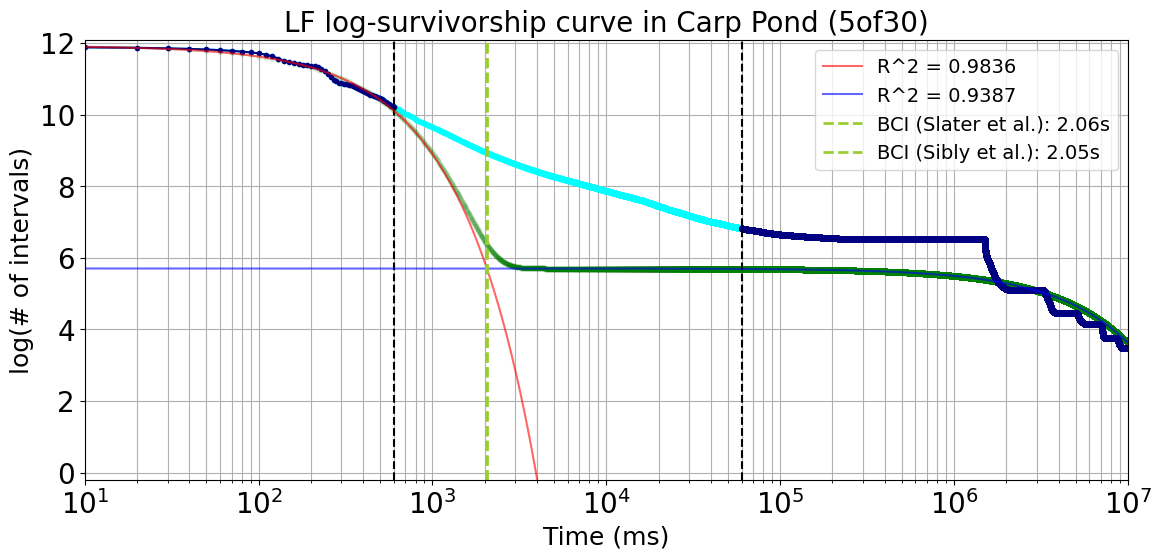

In [12]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '5of30'
data_params['bin_size'] = '30'
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = False
data_params['use_kmeans'] = True
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle_and_bins(file_paths, data_params['cur_dc_tag'], data_params['bin_size'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

Fagen&Young method has 1458229243 missassigned points
Slater method has 1413260 missassigned points
Sibly method has 1371979 missassigned points
Optim BCI has less misassignments than BCI? True
41280 more points assigned correctly


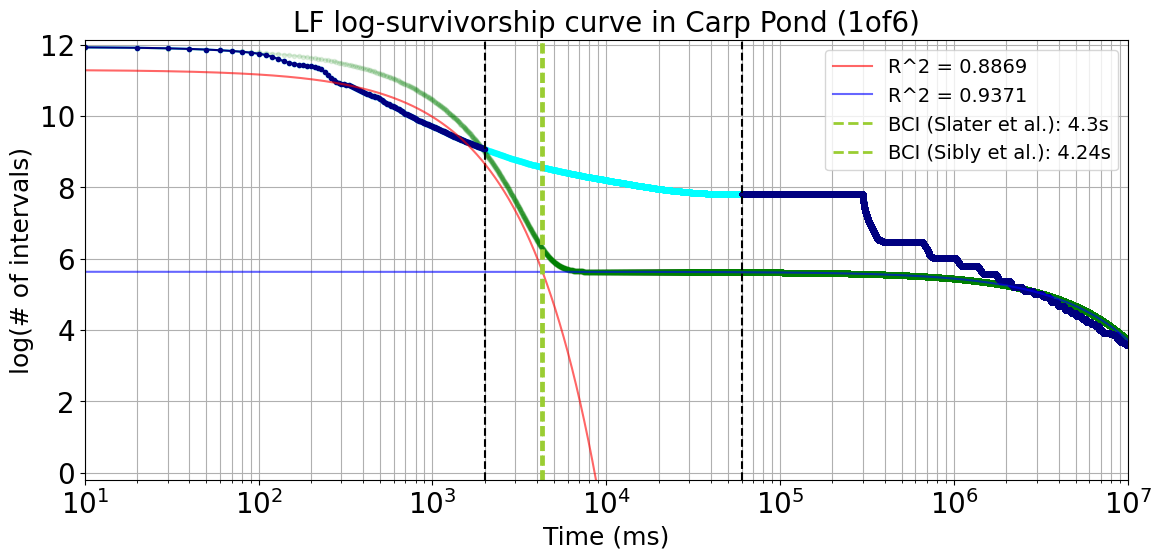

In [13]:
data_params = dict()
data_params['type_tag'] = freq_key
data_params['site_tag'] = site_key
data_params['cur_dc_tag'] = '1of6'
data_params['bin_size'] = '30'
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = False
data_params['use_kmeans'] = True
fig_details['site_name'] = SITE_NAMES[site_key] + ' ' + f"({data_params['cur_dc_tag']})"

file_paths = get_file_paths(data_params)

location_df = ss.prepare_summary_for_plotting_with_duty_cycle_and_bins(file_paths, data_params['cur_dc_tag'], data_params['bin_size'])
ipis_loc, hist_loc = clstr.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = clstr.get_log_survival(hist_loc)

fast_process = clstr.regress_around_fast_intervals(intervals_ms, survival, hist_loc[0])
fast_process = clstr.calculate_exponential_coefficients(fast_process)

slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
slow_process = clstr.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = clstr.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = clstr.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [23]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220727_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [42]:
file_path = Path(files_from_loc[9])
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '30of30'
data_params['bin_size'] = '30'
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = False
data_params['use_kmeans'] = True
file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

In [47]:
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
location_df['file_name'] = pd.DatetimeIndex(pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False)).strftime('%Y%m%d_%H%M%S.WAV')
file_dets = location_df.loc[location_df['file_name']==filename].copy()
file_dets

index_in_file  peak_frequency  index_in_summary        input_file_dt  \
236573              0         40320.0            238628  2022-07-28 07:00:00   
236574              1         40320.0            238629  2022-07-28 07:00:00   
236575              2         39360.0            238630  2022-07-28 07:00:00   
236576              3         40320.0            238631  2022-07-28 07:00:00   
236577              4         39360.0            238632  2022-07-28 07:00:00   
...               ...             ...               ...                  ...   
238416           1871         22080.0            240499  2022-07-28 07:00:00   
238417           1872         20160.0            240500  2022-07-28 07:00:00   
238418           1873         20160.0            240501  2022-07-28 07:00:00   
238419           1875         22080.0            240503  2022-07-28 07:00:00   
238420           1876         22080.0            240504  2022-07-28 07:00:00   

       freq_group                       ref_time  \
236573         HF  2022-07-28 07:00:17.813500000   
236574         HF  2022-07-28 07:00:19.450500000   
236575         HF  2022-07-28 07:00:19.574500000   
236576         HF  2022-07-28 07:00:19.677500000   
236577         HF  2022-07-28 07:00:19.766500000   
...           ...                            ...   
238416         LF  2022-07-28 07:29:52.909500000   
238417         LF  2022-07-28 07:29:53.176500000   
238418         LF  2022-07-28 07:29:53.752500000   
238419         LF  2022-07-28 07:29:54.470500000   
238420         LF  2022-07-28 07:29:54.760500000   

                      call_start_time                  call_end_time  \
236573  2022-07-28 07:00:17.813500000  2022-07-28 07:00:17.822000000   
236574  2022-07-28 07:00:19.450500000  2022-07-28 07:00:19.459200000   
236575  2022-07-28 07:00:19.574500000  2022-07-28 07:00:19.584000000   
236576  2022-07-28 07:00:19.677500000  2022-07-28 07:00:19.686200000   
236577  2022-07-28 07:00:19.766500000  2022-07-28 07:00:19.774900000   
...                               ...                            ...   
238416  2022-07-28 07:29:52.909500000  2022-07-28 07:29:52.924800000   
238417  2022-07-28 07:29:53.176500000  2022-07-28 07:29:53.192000000   
238418  2022-07-28 07:29:53.752500000  2022-07-28 07:29:53.766700000   
238419  2022-07-28 07:29:54.470500000  2022-07-28 07:29:54.486800000   
238420  2022-07-28 07:29:54.760500000  2022-07-28 07:29:54.778700000   

        start_time   end_time  ...                  class  class_prob  \
236573     17.8135    17.8220  ...  Pipistrellus nathusii       0.493   
236574     19.4505    19.4592  ...  Pipistrellus nathusii       0.452   
236575     19.5745    19.5840  ...  Pipistrellus nathusii       0.550   
236576     19.6775    19.6862  ...  Pipistrellus nathusii       0.602   
236577     19.7665    19.7749  ...  Pipistrellus nathusii       0.541   
...            ...        ...  ...                    ...         ...   
238416   1792.9095  1792.9248  ...       Nyctalus noctula       0.468   
238417   1793.1765  1793.1920  ...       Nyctalus noctula       0.509   
238418   1793.7525  1793.7667  ...       Nyctalus noctula       0.482   
238419   1794.4705  1794.4868  ...       Nyctalus noctula       0.273   
238420   1794.7605  1794.7787  ...       Nyctalus noctula       0.380   

       det_prob individual                                         input_file  \
236573    0.523         -1  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...   
236574    0.507         -1  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...   
236575    0.614         -1  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...   
236576    0.683         -1  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...   
236577    0.618         -1  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...   
...         ...        ...                                                ...   
238416    0.590         -1  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...   
238417    0.641         -1  /mnt

In [50]:
def get_bout_params_from_location(location_sum_df, data_params):
    """
    Given a location summary and the location it corresponds to, calculate the BCIs for each frequency group in the summary
    """

    bout_params = dict()
    bout_params['site_key'] = data_params['site_tag']

    for group in location_sum_df['freq_group'].unique():
        if group != '':
            freq_group_df = location_sum_df.loc[location_sum_df['freq_group']==group].copy()
            if not(freq_group_df.empty):
                ipis_loc, hist_loc = clstr.get_histogram(freq_group_df, 10)
                intervals_ms, survival = clstr.get_log_survival(hist_loc)
                fast_process = clstr.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
                fast_process = clstr.calculate_exponential_coefficients(fast_process)
                slow_process = clstr.regress_around_slow_intervals(intervals_ms, survival)
                slow_process = clstr.calculate_exponential_coefficients(slow_process)
                nlin_results, misassigned_points_optim = clstr.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
                bout_params[f'{group}_bci'] = nlin_results['bci']

    return bout_params

In [44]:
plot_dets_no_dutycycle = file_dets.loc[np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))]

In [48]:
batdetect2_predictions = ss.simulate_dutycycle_on_detections_with_bins(location_df, data_params['cur_dc_tag'], data_params['bin_size'])
bout_params = bt.get_bout_params_from_location(location_df, data_params)
bout_params

{'site_key': 'Carp',
 'LF_bci': 2415.2173982170575,
 'HF_bci': 1068.7945358832055}

In [ ]:
batdetect2_preds_with_bouttags = bt.classify_bouts_in_detector_preds_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

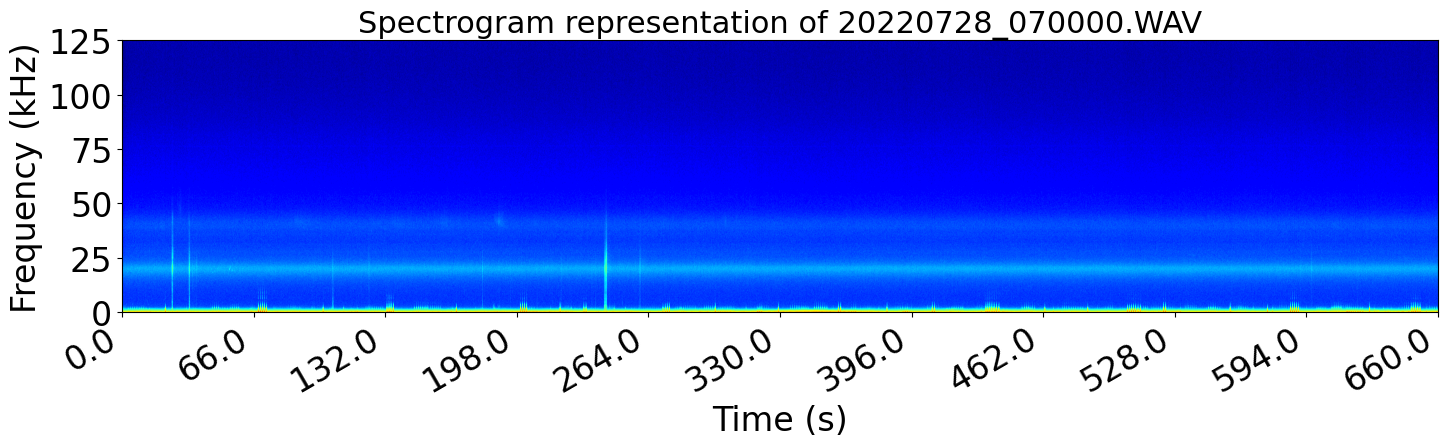

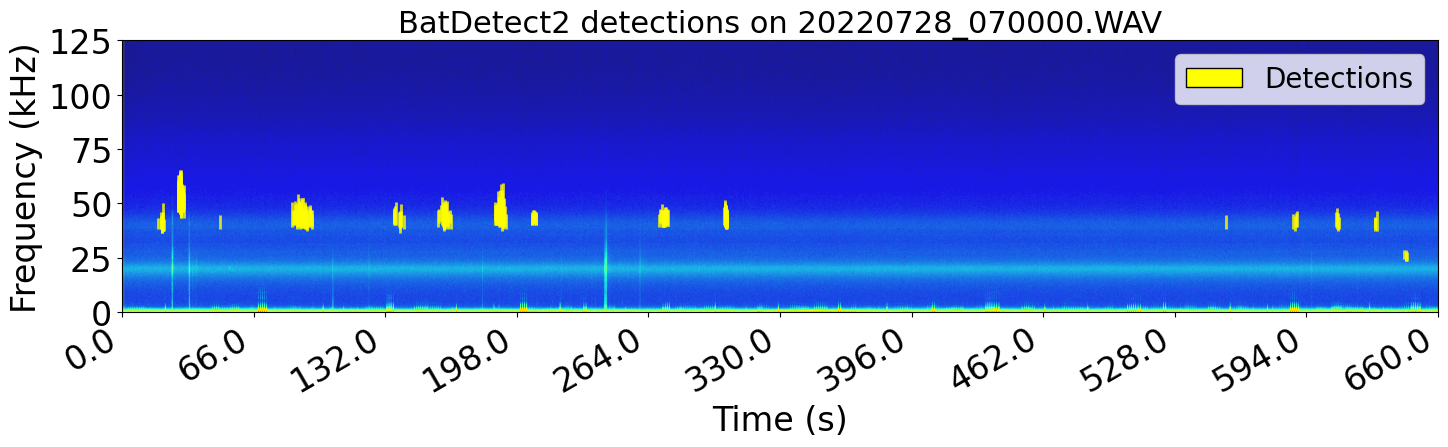

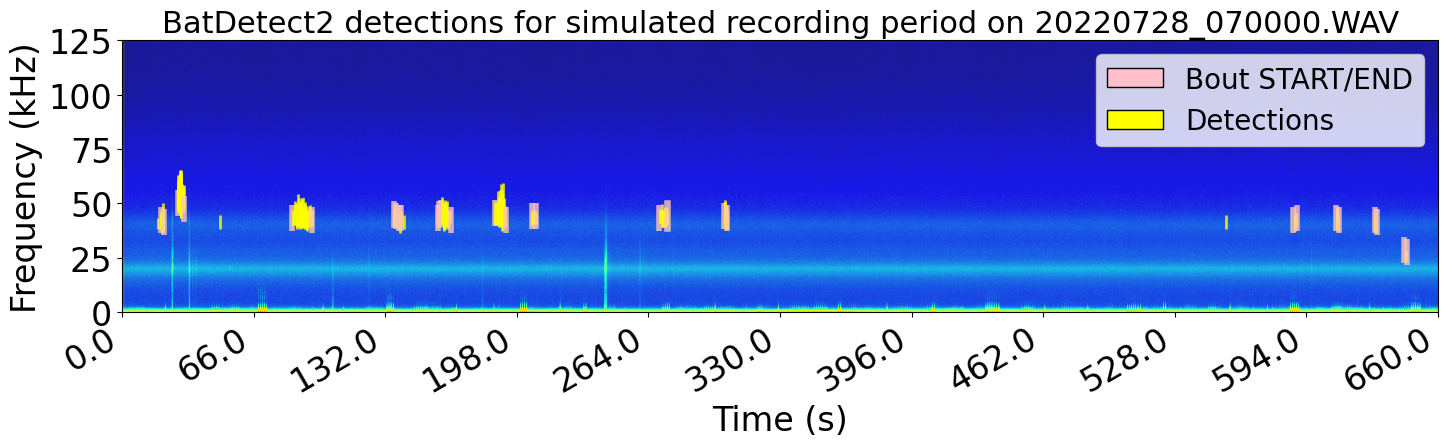

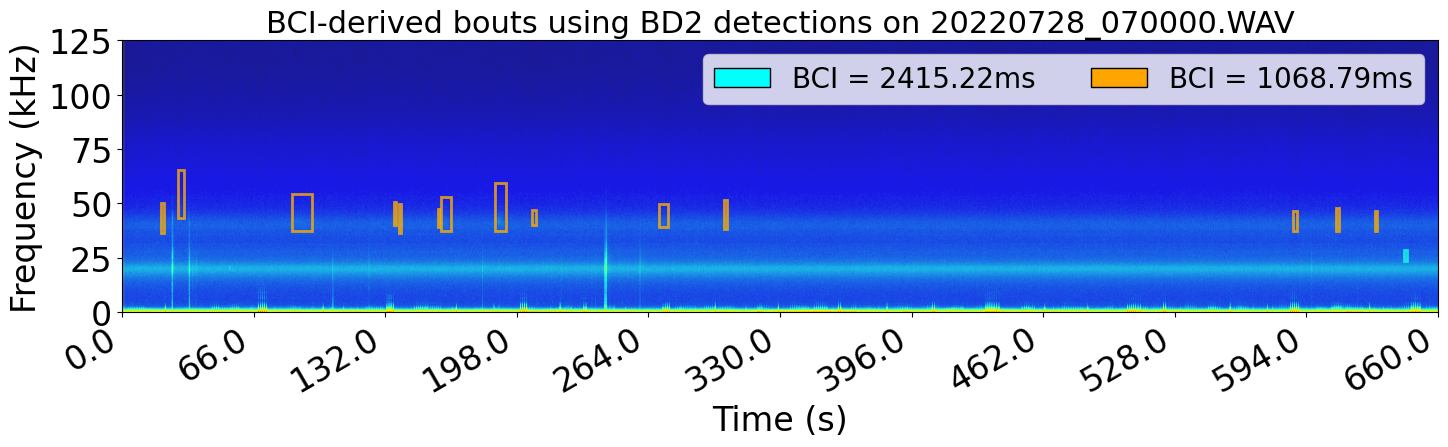

In [29]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, data_params)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [30]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = file_dets.loc[np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

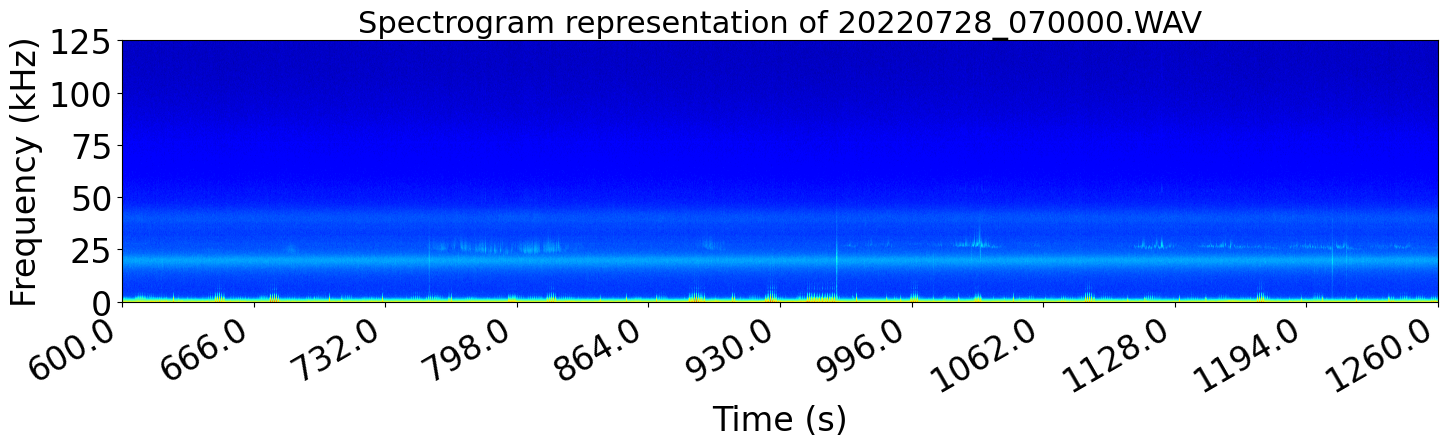

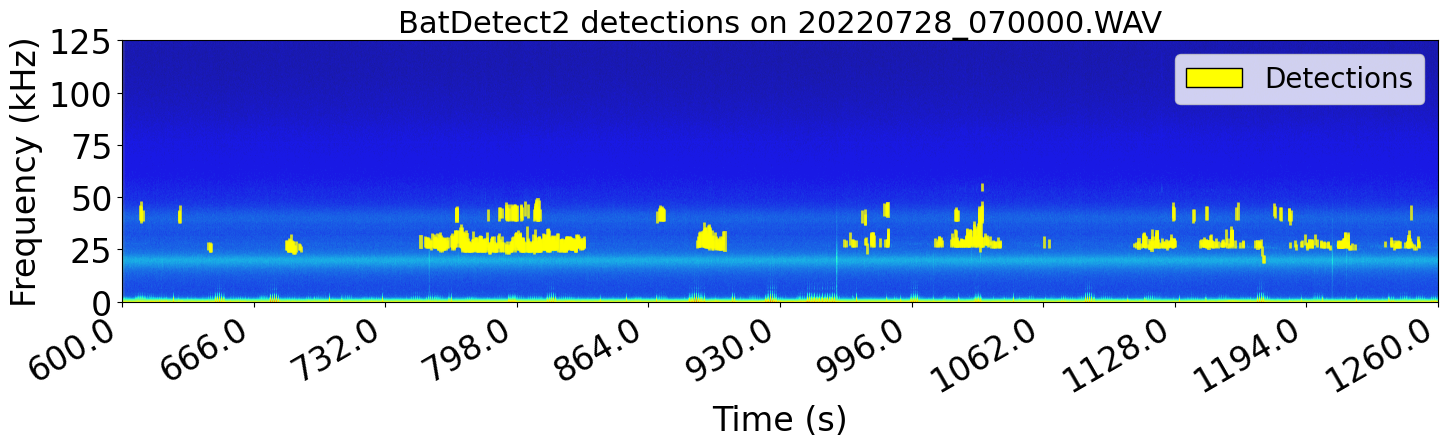

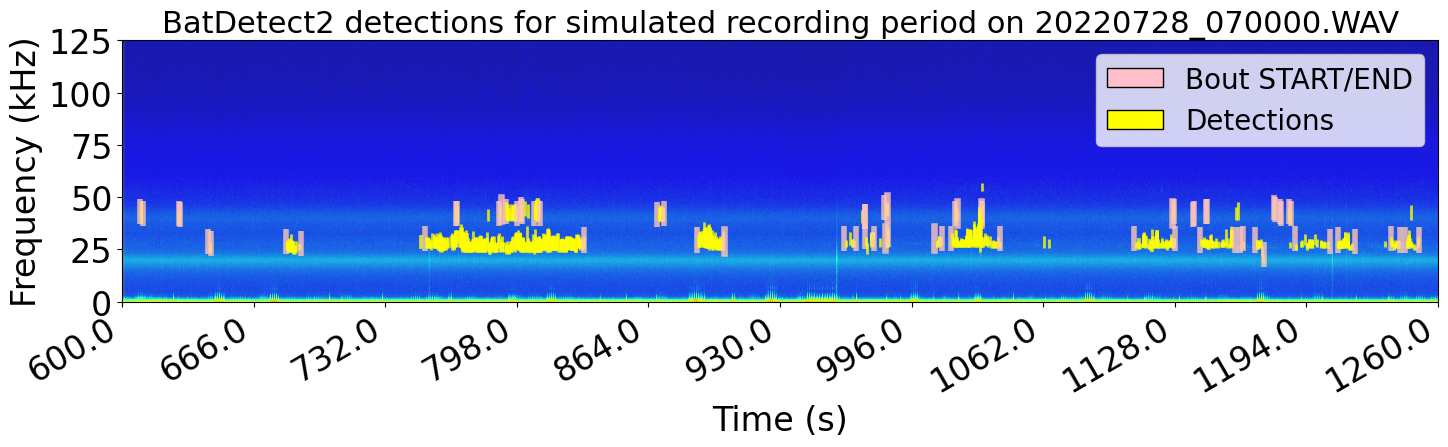

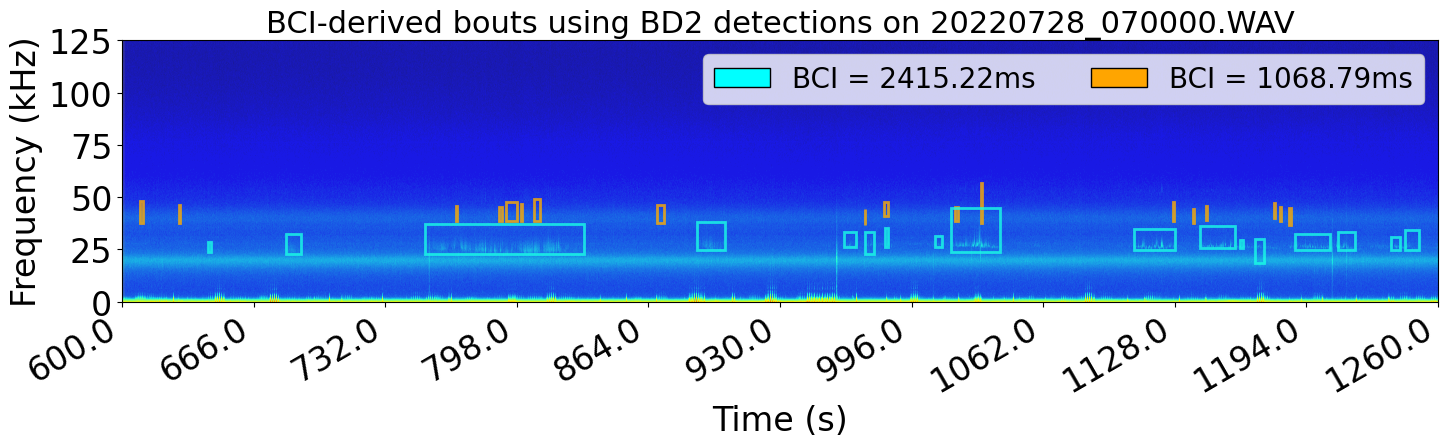

In [31]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, data_params)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)

In [32]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = file_dets.loc[np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

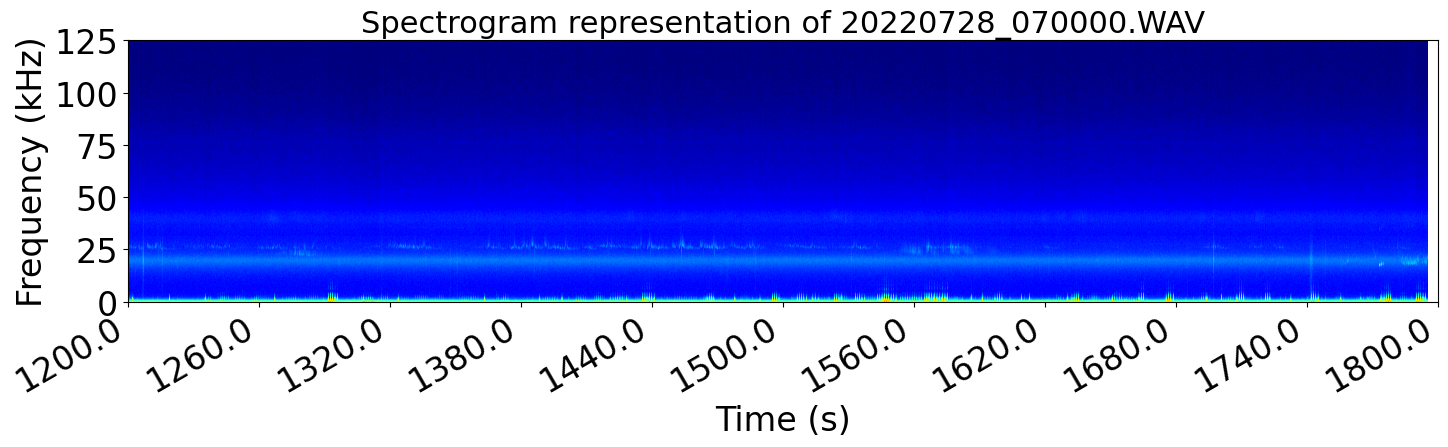

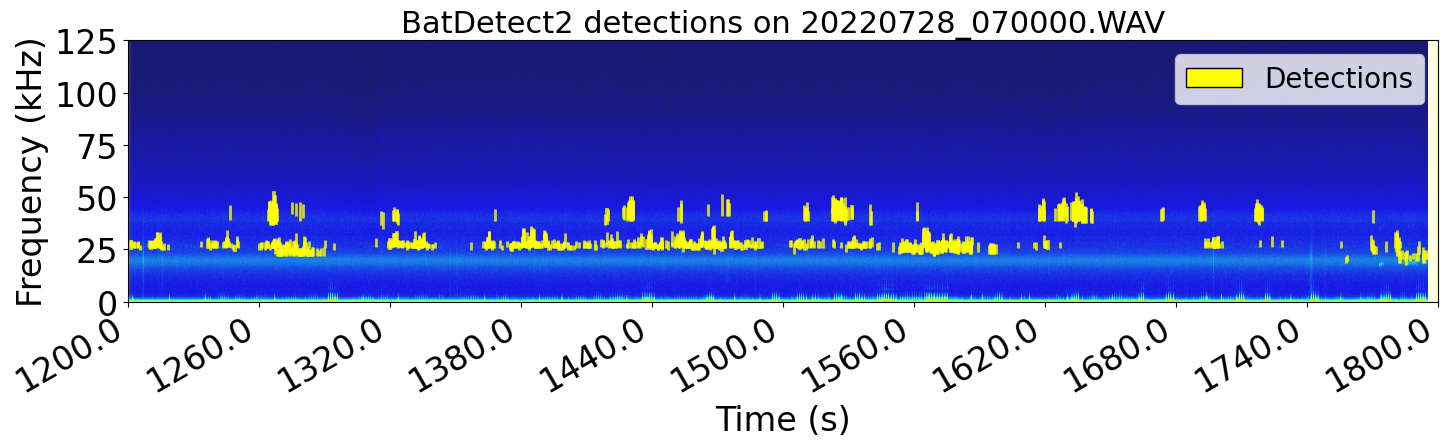

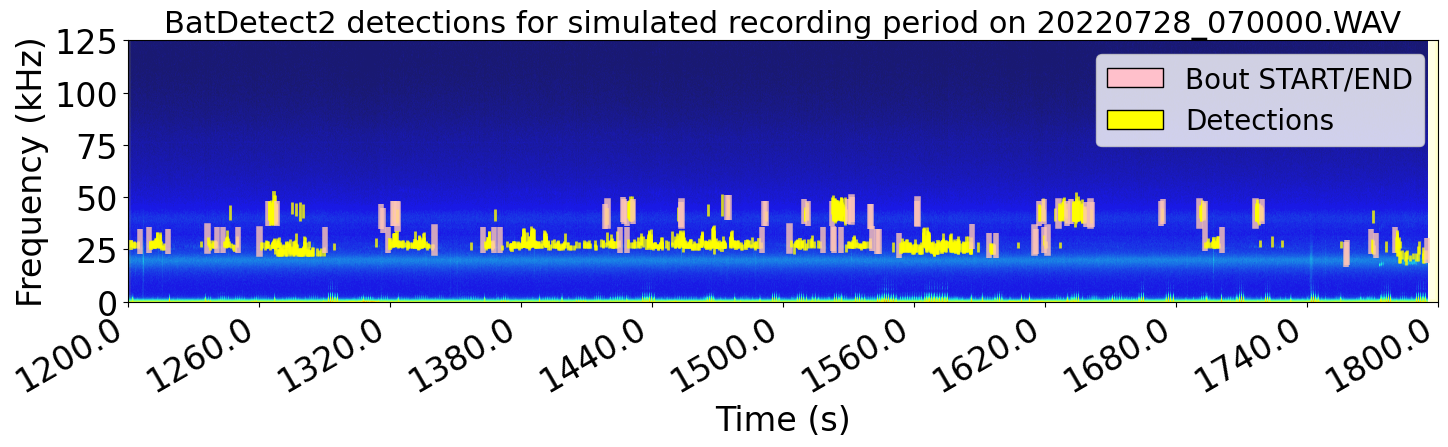

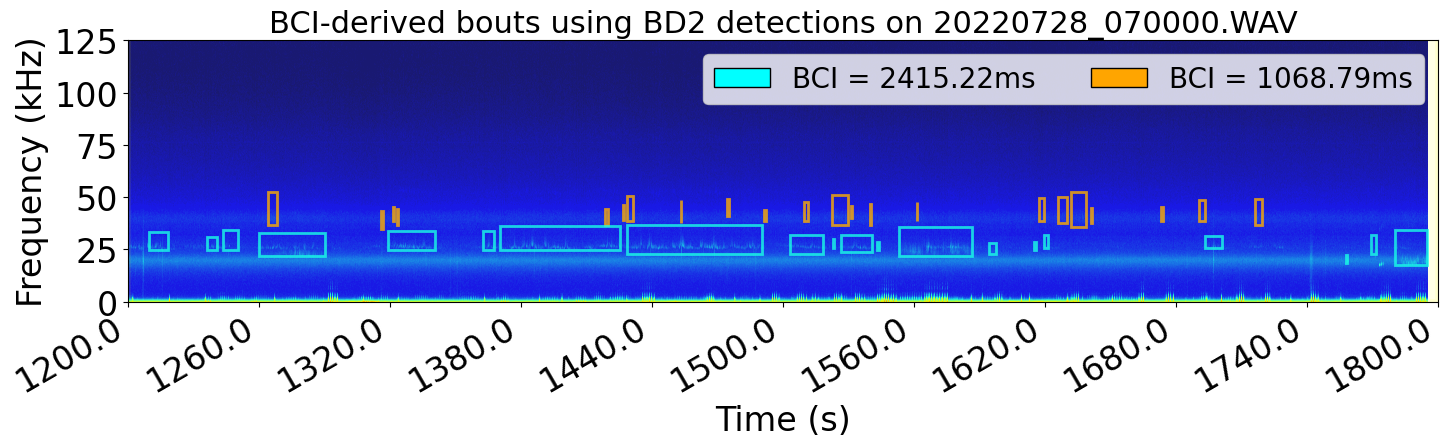

In [33]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, data_params)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_bouts)